In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [2]:
@model function coin_model()
    
    a = datavar(Float64)
    b = datavar(Float64)
    y = datavar(Float64)
    
    θ ~ Beta(a, b)
    y ~ Bernoulli(θ)
    
    return y, a, b, θ
end

coin_model (generic function with 1 method)

In [15]:
N = 100000   # number of coin tosses
p = 0.5    # p parameter of the Bernoulli distribution

dataset = float.(rand(Bernoulli(p), N));

In [11]:
function inference(data)
    model, (y, a, b, θ) = coin_model()
    
    prior_a = 1.0
    prior_b = 1.0
    
    fe = Vector{Float64}()
    θs = Vector{Marginal}()
    
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, AsapScheduler()), (f) -> push!(fe, f))
    θ_sub = subscribe!(getmarginal(θ), (m) -> push!(θs, m))
    
    for d in data
        update!(a, prior_a)
        update!(b, prior_b)
        update!(y, d)

        prior_a, prior_b = params(getdata(θs[end]))
    end
    
    unsubscribe!(θ_sub)
    unsubscribe!(fe_sub)
    
    return θs, fe
end

inference (generic function with 1 method)

In [16]:
est, fe = inference(dataset);

In [13]:
using Plots

gr()

Plots.GRBackend()

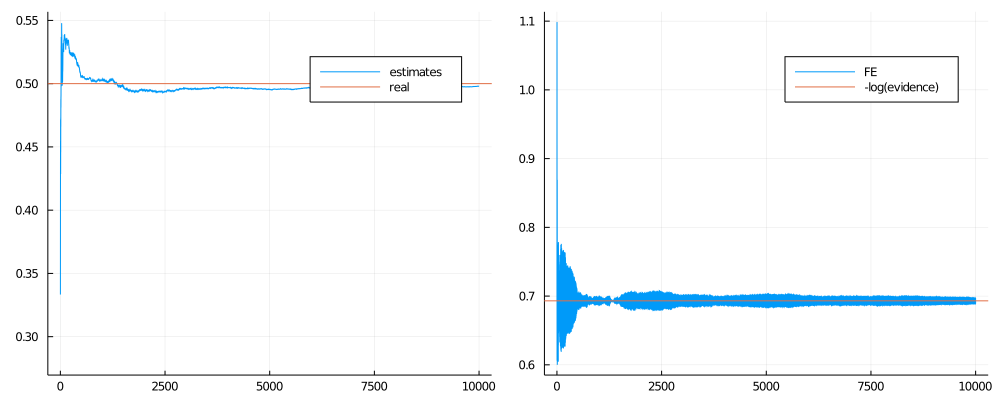

In [17]:
pest = est[1:10:end]
pfe = fe[1:10:end]

p1 = plot(mean.(pest), ribbon = var.(pest), label = :estimates)
p1 = plot!([ p ], seriestype = :hline, label = :real)
 
p2 = plot(pfe, label = :FE)
p2 = plot!([ -log(p) ], seriestype = :hline, label = "-log(evidence)")

plot(p1, p2, layout = @layout([ a b ]), size = (1000, 400))